# TEST ON Regular Season

In [1]:
from ift6758.data.nhl_data_parser import NHLDataParser
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score,RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
import wandb
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the data
data_parser = NHLDataParser()
test_df = data_parser.get_shot_and_goal_pbp_df_for_season(2020, with_playoff_season=True)

In [3]:
#Convert shotAngle, shotDistance to float

test_df['shotAngle'] = test_df['shotAngle'].astype(float)   
test_df['shotDistance'] = test_df['shotDistance'].astype(float)

In [4]:
test_regular_season = test_df[test_df['gameId'].astype(str).str[5] == '2']
test_playoff = test_df[test_df['gameId'].astype(str).str[5] == '3']

In [5]:
#Data Preprocessing
def preprocess_data(train_df,scaling = False):
    dropped_columns = ['gameId',
                   'timeRemaining',
                   'periodNumber',
                   'timeInPeriod',
                   'xCoord',
                   'yCoord',
                   'zoneCode',
                   'shootingTeam',
                   'shootingPlayer',
                   'previousEventX',
                   'previousEventY',
                   'goalieInNet',
                   'shootingTeamSide',
                   ]
    numeric_columns = ['shotDistance',
                       'shotAngle',
                       'timeDiff',
                       'distanceDiff',
                       'shotAngleDiff',
                       'speed']
    train_df_clean = train_df.drop(columns=dropped_columns)

    #Drop rows with missing values
    train_df_clean = train_df_clean.dropna()
    
    #scale the numerical columns
    if scaling:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        train_df_clean[numeric_columns] = scaler.fit_transform(train_df_clean[numeric_columns])
    
   

    #one hot encoding
    train_df_clean = pd.get_dummies(train_df_clean,columns = ['shotType','previousEvent'])

    
    
    return train_df_clean






In [6]:
#default values
project_name = "IFT6758.2024-B08"
entity_name = "team08"
dir_path = os.getenv('WANDB_DIR')


In [ ]:

model_list = ['Decision_Tree:latest',
              'Linear_SVC:latest',
              'Kernel_SVC:latest',
              'Logistic_Regression:latest',
              'Random_Forest:latest',
              'lg_distance:latest',
              'lg_angle:latest',
              'lg_angle_distance:latest',
              'xgb_Final:latest']


# Initialize wandb
wandb.init(project=project_name, entity=entity_name, dir=dir_path)

# Download the model from wandb
for name in model_list:
    model_artifact = wandb.use_artifact(name)
    model_dir = model_artifact.download()
    model_file_name = os.path.basename(model_dir)
wandb.finish()





In [7]:
#load the models
import joblib
d_tree = joblib.load('artifacts\\Decision_Tree-v0\\decision_tree_undersample_newfeatures.pkl')
linear_svc = joblib.load('artifacts\\Linear_SVC-v0\\linearSvc_balanced_Kfold_newfeatures.pkl')
kernel_svc = joblib.load('artifacts\\Kernel_SVC-v0\\svc_balanced_Kfold_newfeatures.pkl')
lg_best = joblib.load('artifacts\\Logistic_Regression-v0\\logistic_newfeatures.pkl')
random_forest = joblib.load('artifacts\\Random_Forest-v0\\random_forest_balanced_newfeatures.pkl')
lg_distance = joblib.load('artifacts\\lg_distance-v0\\lg_distance.pkl')
lg_angle = joblib.load('artifacts\\lg_angle-v0\\lg_angle.pkl')
lg_angle_distance = joblib.load('artifacts\\lg_angle_distance-v0\\lg_distance_angle.pkl')
xgb = joblib.load('artifacts\\xgb_Final-v0\\xgb_final.pkl')


#make a dictionary of models
models = {'Random Forest':random_forest,
          'Logistic Regression Distance':lg_distance,
          'Logistic Regression Angle':lg_angle,
          'Logistic Regression Angle Distance':lg_angle_distance,
          'XGBoost':xgb}


## Best Model

In [8]:
test_df_clean= preprocess_data(pd.concat([test_regular_season,test_playoff]))
test_df_clean_regular_season = test_df_clean[test_df['gameId'].astype(str).str[5] == '2']
test_df_clean_playoff = test_df_clean[test_df['gameId'].astype(str).str[5] == '3']


X_test_regular = test_df_clean_regular_season.drop(columns=['isGoal'])
y_test_rf_regular = test_df_clean_regular_season['isGoal']
prob_scores_rf_regular = random_forest.predict_proba(X_test_regular)[:,1]

X_test_playoff = test_df_clean_playoff.drop(columns=['isGoal'])
y_test_rf_playoff = test_df_clean_playoff['isGoal']
prob_scores_rf_playoff = random_forest.predict_proba(X_test_playoff)[:,1]


C:\Users\gogig\AppData\Local\Temp\ipykernel_15416\317202218.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df_clean_regular_season = test_df_clean[test_df['gameId'].astype(str).str[5] == '2']
C:\Users\gogig\AppData\Local\Temp\ipykernel_15416\317202218.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df_clean_playoff = test_df_clean[test_df['gameId'].astype(str).str[5] == '3']


# Logistic Regression : Angle

In [9]:
X_test_regular = test_regular_season[['shotAngle']]
y_test_lg_angle_regular = test_regular_season['isGoal']
prob_scores_lg_angle_regular = lg_angle.predict_proba(X_test_regular)[:,1]

X_test_playoff = test_playoff[['shotAngle']]
y_test_lg_angle_playoff = test_playoff['isGoal']
prob_scores_lg_angle_playoff = lg_angle.predict_proba(X_test_playoff)[:,1]

# Logistic Regression : Distance

In [10]:
X_test_regular = test_regular_season[['shotDistance']]
y_test_lg_distance_regular = test_regular_season['isGoal']
prob_scores_lg_distance = lg_distance.predict_proba(X_test_regular)[:,1]

X_test_playoff = test_playoff[['shotDistance']]
y_test_lg_distance_playoff = test_playoff['isGoal']
prob_scores_lg_distance_playoff = lg_distance.predict_proba(X_test_playoff)[:,1]


# Logistic Regression : Angle and Distance

In [11]:
X_test_regular = test_regular_season[['shotDistance','shotAngle']]
y_test_angle_distance_regular = test_regular_season['isGoal']
prob_scores_lg_angle_distance_regular = lg_angle_distance.predict_proba(X_test_regular)[:,1]

X_test_playoff = test_playoff[['shotDistance','shotAngle']]
y_test_angle_distance_playoff = test_playoff['isGoal']
prob_scores_lg_angle_distance_playoff = lg_angle_distance.predict_proba(X_test_playoff)[:,1]


# XgBoost

In [12]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
X_test_regular = test_regular_season[['periodNumber',
                   'shotAngle', 
                   'shotDistance', 
                   'shotType', 
                   'xCoord',
                   'yCoord', 
                   'previousEventX', 
                   'previousEventY', 
                   'rebound', 
                   'timeDiff',
                   'distanceDiff', 
                   'shotAngleDiff', 
                   'speed']]
X_test_regular['shotType'] = encoder.fit_transform(X_test_regular['shotType'])
y_test_xgboost_regular = test_regular_season['isGoal']
prob_scores_xgb_regular = xgb.predict_proba(X_test_regular)[:,1]

X_test_playoff = test_playoff[['periodNumber',
                   'shotAngle', 
                   'shotDistance', 
                   'shotType', 
                   'xCoord',
                   'yCoord', 
                   'previousEventX', 
                   'previousEventY', 
                   'rebound', 
                   'timeDiff',
                   'distanceDiff', 
                   'shotAngleDiff', 
                   'speed']]
X_test_playoff['shotType'] = encoder.fit_transform(X_test_playoff['shotType'])
y_test_xgboost_playoff = test_playoff['isGoal']
prob_scores_xgb_playoff = xgb.predict_proba(X_test_playoff)[:,1]


C:\Users\gogig\AppData\Local\Temp\ipykernel_15416\524273571.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_regular['shotType'] = encoder.fit_transform(X_test_regular['shotType'])
C:\Users\gogig\AppData\Local\Temp\ipykernel_15416\524273571.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_playoff['shotType'] = encoder.fit_transform(X_test_playoff['shotType'])


# Graphs

In [13]:
# Collect probabilities from all models as tuples :(name,scores,y_test) for regular season and playoff
model_scores_regular = [('Random Forest',prob_scores_rf_regular,y_test_rf_regular),
                        ('Logistic Regression Distance',prob_scores_lg_distance,y_test_lg_distance_regular),
                        ('Logistic Regression Angle',prob_scores_lg_angle_regular,y_test_lg_angle_regular),
                        ('Logistic Regression Angle Distance',prob_scores_lg_angle_distance_regular,y_test_angle_distance_regular),
                        ('XGBoost',prob_scores_xgb_regular,y_test_xgboost_regular)]

model_scores_playoff = [('Random Forest',prob_scores_rf_playoff,y_test_rf_playoff),
                        ('Logistic Regression Distance',prob_scores_lg_distance_playoff,y_test_lg_distance_playoff),
                        ('Logistic Regression Angle',prob_scores_lg_angle_playoff,y_test_lg_angle_playoff),
                        ('Logistic Regression Angle Distance',prob_scores_lg_angle_distance_playoff,y_test_angle_distance_playoff),
                        ('XGBoost',prob_scores_xgb_playoff,y_test_xgboost_playoff)]


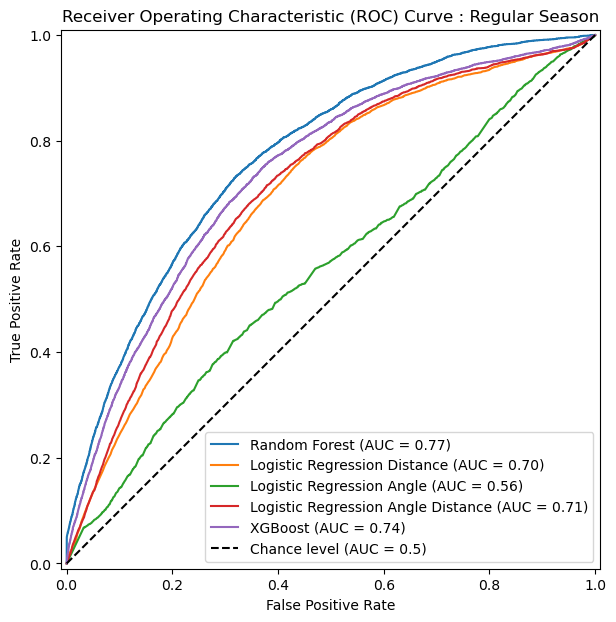

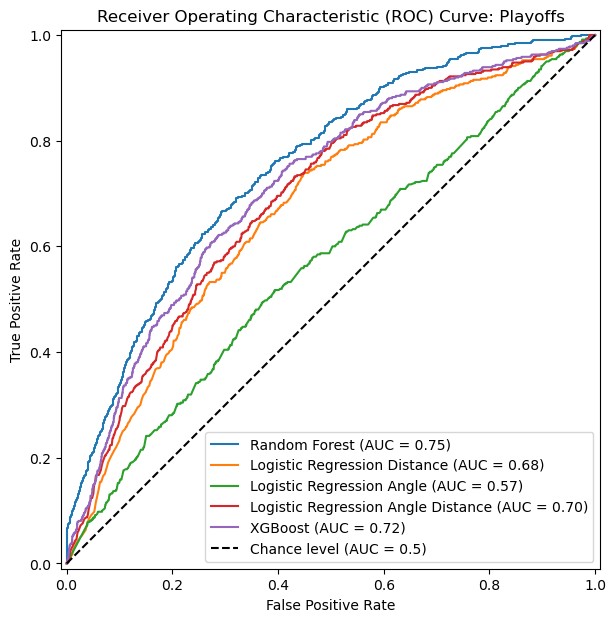

In [56]:
##Graph 1: Roc Curve

fig_1_regular, ax_1_regular = plt.subplots()
roc_regular = {}
plot_random = False #This is just to make sure that the random classifier is only plotted once

#Plot the ROC curve for each classifier for regular season
for name , prob_score , y_test in model_scores_regular :
    if name == 'XGBoost': #Only plot the random classifier once at the end
        plot_random = True  
    roc_regular[name] = RocCurveDisplay.from_predictions(y_test, prob_score , plot_chance_level=plot_random, ax=ax_1_regular,name=name)
ax_1_regular.set_title('Receiver Operating Characteristic (ROC) Curve : Regular Season')
ax_1_regular.set_xlabel('False Positive Rate')
ax_1_regular.set_ylabel('True Positive Rate')
fig_1_regular.set_size_inches(7,7)
fig_1_regular.savefig('roc_curve_task7_regular.png')

#Graph 2: Precision Recall Curve
fig_1_playoff, ax_1_playoff = plt.subplots()
roc_playoff = {}
plot_random = False #This is just to make sure that the random classifier is only plotted once

#Plot the ROC curve for each classifier for playoffs
for name , prob_score , y_test in model_scores_playoff :
    if name == 'XGBoost': #Only plot the random classifier once at the end
        plot_random = True  
    roc_playoff[name] = RocCurveDisplay.from_predictions(y_test, prob_score , plot_chance_level=plot_random, ax=ax_1_playoff,name=name)
ax_1_playoff.set_title('Receiver Operating Characteristic (ROC) Curve: Playoffs')
ax_1_playoff.set_xlabel('False Positive Rate')
ax_1_playoff.set_ylabel('True Positive Rate')
fig_1_playoff.set_size_inches(7,7)
fig_1_playoff.savefig('roc_curve_task7_playoff.png')





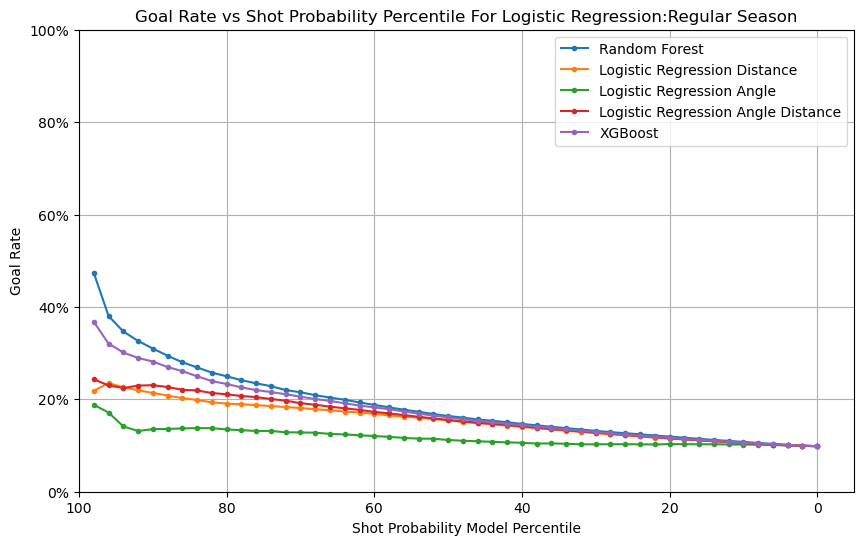

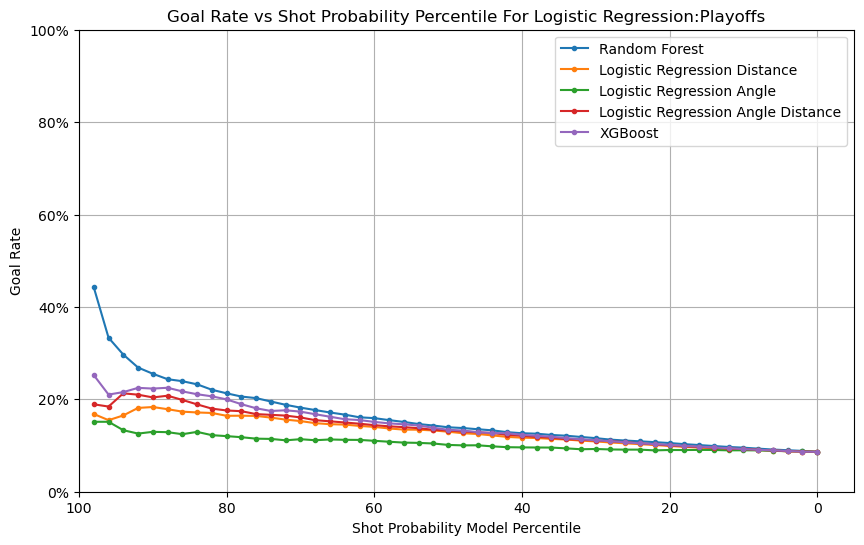

In [57]:
#Graph 2: Goal Rate as a Function of Shot Probability Model Percentile

# Calculate the percentiles for the shot probabilities for all models for regular season
percentile_bins = np.arange(0, 100, 2)
percentiles_regular = {}
for name, prob_score,_ in model_scores_regular:
    percentile_data = np.percentile(prob_score , percentile_bins)
    percentiles_regular[name] = percentile_data


# Calculate the goal rates for each percentile for all models for regular season
goal_rates_regular = {}
for name, prob_score,y_test in model_scores_regular:
    goal_rates_regular[name] = []
    for percentile in percentiles_regular[name]:
        mask = prob_score  >= percentile
        goal_rates_regular[name].append(y_test[mask].mean())


# Plot the goal rate as a function of the shot probability model percentile for all models

fig_2_regular, ax_2_regular = plt.subplots()
for name, goal_rate in goal_rates_regular.items():
    ax_2_regular.plot(percentile_bins, goal_rate, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Goal Rate')
plt.title('Goal Rate vs Shot Probability Percentile For Logistic Regression:Regular Season')
plt.grid(True)
plt.legend()
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, -5)
fig_2_regular.set_size_inches(10,6)
plt.show()
fig_2_regular.savefig('goal_rate_task7_regular.png')

# Calculate the percentiles for the shot probabilities for all models for playoffs
percentiles_playoff = {}
for name, prob_score,_ in model_scores_playoff:
    percentile_data = np.percentile(prob_score , percentile_bins)
    percentiles_playoff[name] = percentile_data

# Calculate the goal rates for each percentile for all models for playoffs
goal_rates_playoff = {}
for name, prob_score,y_test in model_scores_playoff:
    goal_rates_playoff[name] = []
    for percentile in percentiles_playoff[name]:
        mask = prob_score  >= percentile
        goal_rates_playoff[name].append(y_test[mask].mean())

# Plot the goal rate as a function of the shot probability model percentile for all models
fig_2_playoff, ax_2_playoff = plt.subplots()
for name, goal_rate in goal_rates_playoff.items():
    ax_2_playoff.plot(percentile_bins, goal_rate, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Goal Rate')
plt.title('Goal Rate vs Shot Probability Percentile For Logistic Regression:Playoffs')
plt.grid(True)
plt.legend()
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, -5)
fig_2_playoff.set_size_inches(10,6)
plt.show()
fig_2_playoff.savefig('goal_rate_task7_playoff.png')



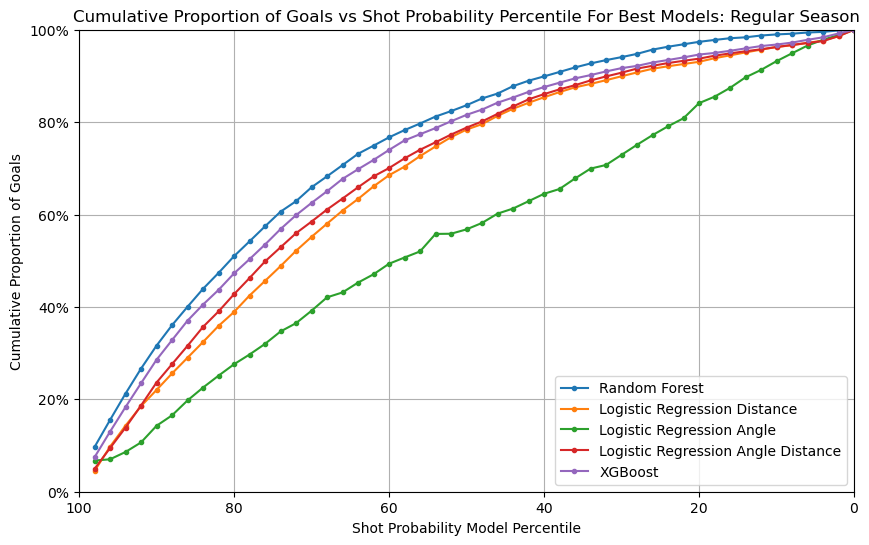

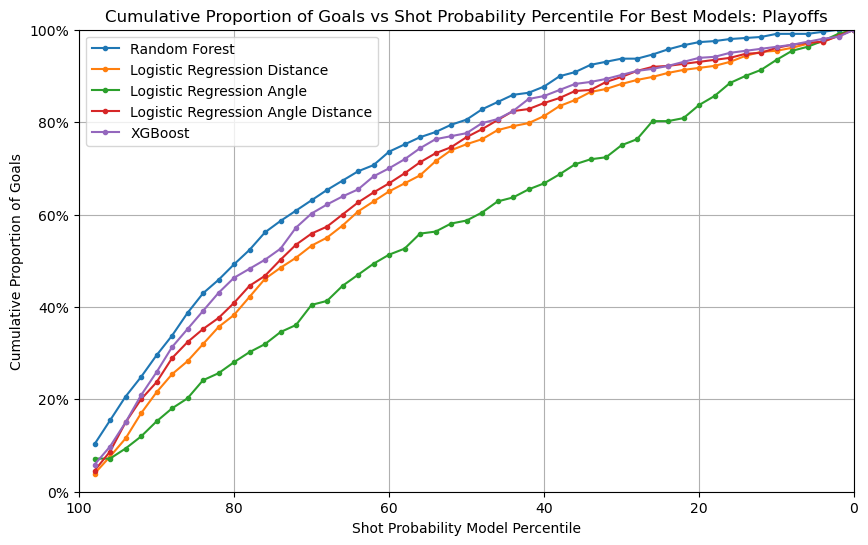

In [58]:
# Graph 3: Cumulative Proportion of Goals as a Function of Shot Probability Model Percentile 

# Calculate the cumulative goal percentage for each percentile for all models for regular season
cumulative_goal_proportions_regular = {}
for name, prob_score, y_test in model_scores_regular:
    cumulative_goal_proportions_regular[name] = []
    for percentile in percentiles_regular[name]:
        mask = prob_score  >= percentile
        cumulative_goal_proportions_regular[name].append(y_test[mask].sum() / y_test.sum())


# Plot the cumulative proportion of goals as a function of the shot probability model percentile for all models
fig_3_regular, ax_3_regular = plt.subplots()
for name, cumulative_goal_proportion in cumulative_goal_proportions_regular.items():
    ax_3_regular.plot(percentile_bins, cumulative_goal_proportion, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Cumulative Proportion of Goals')
plt.title('Cumulative Proportion of Goals vs Shot Probability Percentile For Best Models: Regular Season')
plt.grid(True)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, 0)
plt.legend()
fig_3_regular.set_size_inches(10,6)
plt.show()
fig_3_regular.savefig('cumulative_goal_proportion_task7_regular.png')

# Calculate the cumulative goal percentage for each percentile for all models for playoffs
cumulative_goal_proportions_playoff = {}
for name, prob_score, y_test in model_scores_playoff:
    cumulative_goal_proportions_playoff[name] = []
    for percentile in percentiles_playoff[name]:
        mask = prob_score  >= percentile
        cumulative_goal_proportions_playoff[name].append(y_test[mask].sum() / y_test.sum())

# Plot the cumulative proportion of goals as a function of the shot probability model percentile for all models
fig_3_playoff, ax_3_playoff = plt.subplots()
for name, cumulative_goal_proportion in cumulative_goal_proportions_playoff.items():
    ax_3_playoff.plot(percentile_bins, cumulative_goal_proportion, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Cumulative Proportion of Goals')
plt.title('Cumulative Proportion of Goals vs Shot Probability Percentile For Best Models: Playoffs')
plt.grid(True)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, 0)
plt.legend()
fig_3_playoff.set_size_inches(10,6)
plt.show()
fig_3_playoff.savefig('cumulative_goal_proportion_task7_playoff.png')


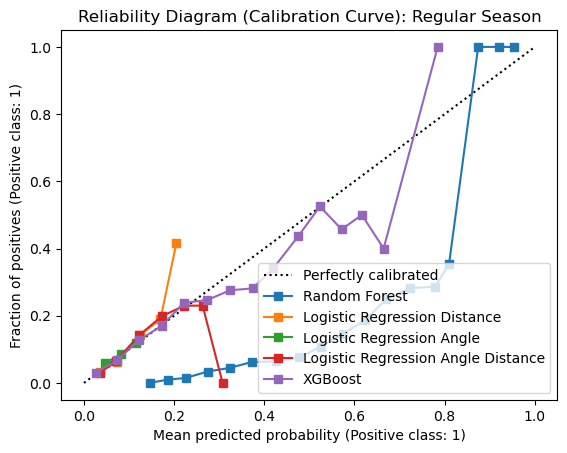

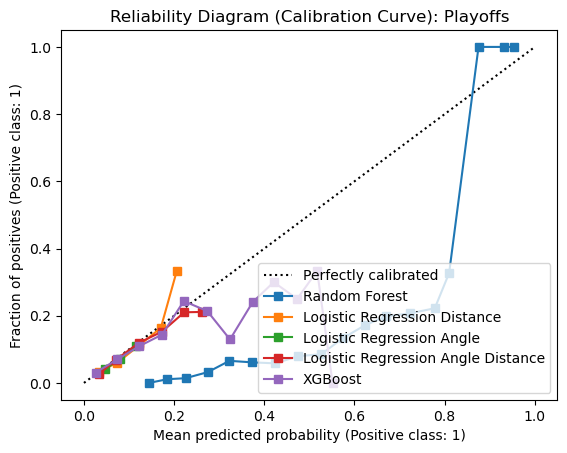

In [15]:
# Graph 4: Calibration Curve

#Plot the calibration curve for each classifier for regular season
fig_4_regular,ax_4_regular = plt.subplots()
for name, prob_score, y_test in  model_scores_regular:
    CalibrationDisplay.from_predictions(y_test, prob_score, n_bins=20, strategy='uniform',ax=ax_4_regular,name=name)
plt.title('Reliability Diagram (Calibration Curve): Regular Season')
plt.show()
fig_4_regular.savefig('calibration_curve_task7_regular.png')

#Plot the calibration curve for each classifier for playoffs
fig_4_playoff,ax_4_playoff = plt.subplots()
for name, prob_score, y_test in  model_scores_playoff:
    CalibrationDisplay.from_predictions(y_test, prob_score, n_bins=20, strategy='uniform',ax=ax_4_playoff,name=name)
plt.title('Reliability Diagram (Calibration Curve): Playoffs')
plt.show()
fig_4_playoff.savefig('calibration_curve_task7_playoff.png')